In [4]:
%pylab inline
import matplotlib.pyplot as plt
import PIL
import numpy as np
from glob import glob
from scipy.cluster.vq import kmeans

Populating the interactive namespace from numpy and matplotlib


Реализация алгортима поиска минимального разреза в графе с помощью графа, построенного при помощи библиотеки networkx и функции для разреза, которую написал руками
При alpha = 0,6 beta = 1,2 мой алгоритм работает с меньшей ошибкой относительно простого отнесения к ближайшему классу

In [0]:
import math


def dist_c(c1, c2):
    return math.sqrt(((c1 - c2)**2).sum())*0.6

def dist_v(c1, c2):
    return (1 / (1 + (math.sqrt(((c1 - c2)**2).sum()) / 255)))*1.2

In [6]:
from google.colab import files
 
imgs = files.upload()

Saving imgonline-com-ua-Resize-hRoVvkpaUnljUkV.jpg to imgonline-com-ua-Resize-hRoVvkpaUnljUkV.jpg
Saving imgonline-com-ua-Resize-kzKanBlUvr3UC2gS.jpg to imgonline-com-ua-Resize-kzKanBlUvr3UC2gS.jpg
Saving imgonline-com-ua-Resize-ZL6R0s0SD3a.jpg to imgonline-com-ua-Resize-ZL6R0s0SD3a.jpg


In [0]:
def apply_cut(img, classes, centers):
    assert len(centers) == 2
    result = np.clip((img + 1)* 255, 0 ,0)
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            if classes[x][y]:
                result[x][y] = img[x][y]
    result = np.clip(result, 0, 255)
    return result

In [0]:
def process_img(img_file, cut_func, centers, show=False):
    img = np.array(PIL.Image.open(img_file))[:, :, :3].astype('int64')

    centers = np.array(centers)
    classes = cut_func(img, centers)
    penalty = get_penalty(img, classes, centers)
    clustered = apply_cut(img, classes, centers)
    
    if show:
        fig = plt.figure(figsize=(16, 8))
        fig.add_subplot(1, 2, 1)
        plt.imshow(img)

        fig.add_subplot(1, 2, 2)
        plt.imshow(clustered)
        plt.show()

    return penalty

In [0]:
def simple_get_centers(img_file):
    img = np.array(PIL.Image.open(img_file))[:, :, :3].astype('float').reshape((-1, 3))
    return kmeans(img.astype('float'), 2)[0].astype('int64')

In [0]:
def get_penalty(img, classes, centers):
    assert len(centers) == 2
    result = 0
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            result += dist_c(img[x][y], centers[classes[x][y]])*2
    return result

In [0]:
def cut_func(img, centers):
    assert len(centers) == 2
    classes = np.zeros_like(img[:, :, 0])
    G = nx.DiGraph()
    s = img.shape[0] * img.shape[1]
    t = s + 1
    n = t + 1
    G = []
    for i in range(n):
        G.append(n * [0])
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            G[s][x * img.shape[1] + y] = sqrt(dist(img[x][y], centers[0]))
            G[x * img.shape[1] + y][t] = sqrt(dist(img[x][y], centers[1]))
    for x in range(img.shape[0]):
        for y in range(img.shape[1] - 1):
            G[x * img.shape[1] + y][x * img.shape[1] + y + 1] = dist_v(img[x][y],img[x][y + 1])
            G[x * img.shape[1] + y + 1][x * img.shape[1] + y] = dist_v(img[x][y],img[x][y + 1])
    for x in range(img.shape[0] - 1):
        for y in range(img.shape[1]):
            G[(x + 1) * img.shape[1] + y][x * img.shape[1] + y] = dist_v(img[x][y],img[x + 1][y])
            G[x * img.shape[1] + y][(x + 1) * img.shape[1] + y] = dist_v(img[x][y],img[x + 1][y])
    partition, cost = my_min_cut(G, n)
    print(cost)
    for i in partition:
        x = i // img.shape[1]
        y = i % img.shape[1]
        if x * img.shape[1] + y == s or x * img.shape[1] + y == t: 
            continue
        classes[x][y] = 1
    return classes

In [0]:
def hand_cut(g, n):
    best_cut = list()
    best_cost = 100000000000000
    v = []
    for i in range(n):
        v.append([])
    for i in range(n):
        v[i] = 1 * [i]
    w = []
    visited = n * [1]
    in_a = n * [0]
    for ph in range(n - 1):
        in_a = n * [0]
        w = n * [0]
        prev = -1
        for it in range(n - ph):
            sel = -1
            for i in range(n):
                if visited[i] and not in_a[i] and (sel == -1 or w[i] > w[sel]):
                    sel = i
            if it == n - ph - 1:
                if w[sel] < best_cost:
                    best_cost = w[sel]
                    best_cut = v[sel]
                v[prev].append(v[sel])
                for i in range(n):
                    g[prev][i] = g[prev][i] + g[sel][i]
                    g[i][prev] = g[i][prev] + g[sel][i]
                visited[sel] = 0
            else:
                in_a[sel] = 1
                for i in range(n):
                    w[i] += g[sel][i]
                prev = sel
    return best_cut, best_cost

Код, который работает без библиотечных функций, считает разрез ооооочень долго, поэтому его я проверил на картинках маленького разрешения

56966.160672662074


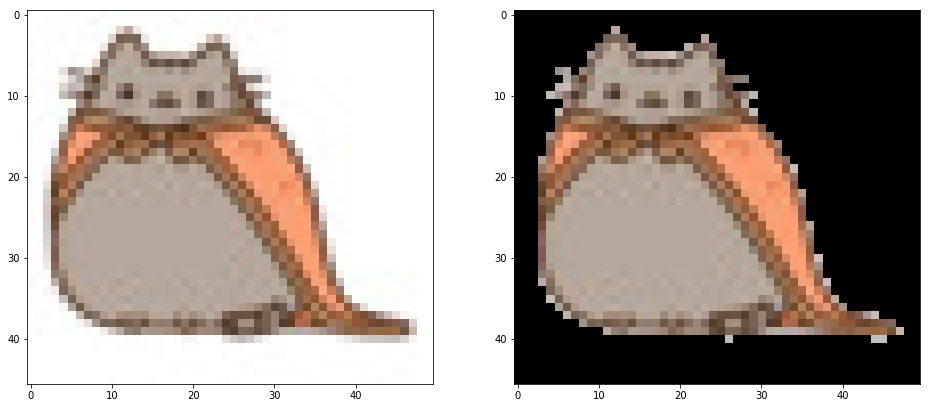

102800.48524697279


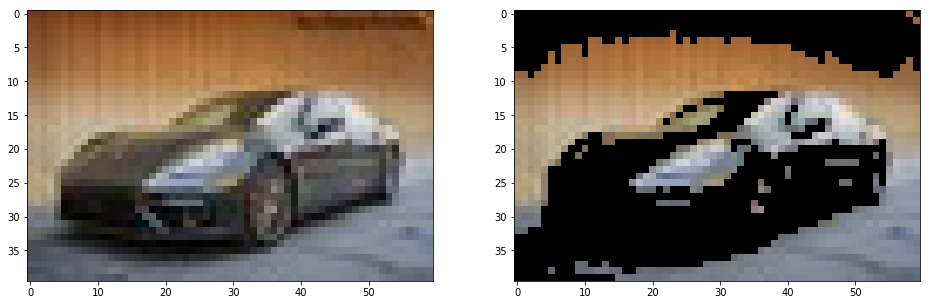

38288.45972125613


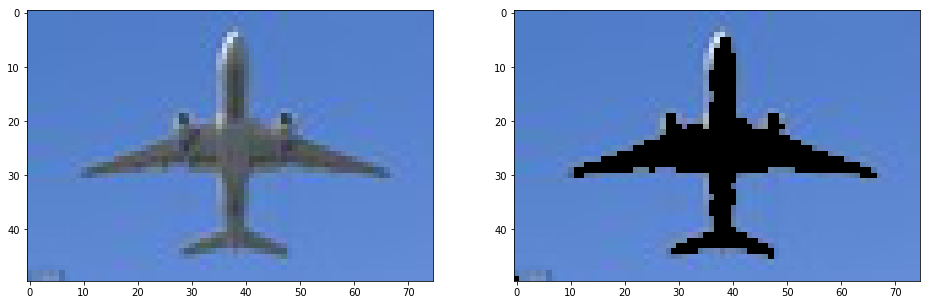

In [13]:
for img in imgs:
    c = simple_get_centers(img)
    process_img(img, hand_cut, c, True)

А здесь первая моя реализация через библиотеку netwokx 

In [0]:
def add_edges(img, G, centres):
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            G.add_edge(img.shape[0]*img.shape[1], i * img.shape[1] + j, capacity = dist_c(centres[0], img[i][j]))
            G.add_edge(i * img.shape[1] + j, img.shape[0]*img.shape[1] + 1, capacity = dist_c(centres[1], img[i][j]))
    for i in range(img.shape[0] - 1):
        for j in range(img.shape[1] - 1):
            G.add_edge(img.shape[1] * i + j, img.shape[1] * (i + 1) + j, capacity = dist_v(img[i][j], img[i+1][j]))
            G.add_edge(img.shape[1] * i + j, img.shape[1] * i + j + 1, capacity = dist_v(img[i][j], img[i][j+1]))
            G.add_edge(img.shape[1] * (1 + i) + j, img.shape[1] * i  + j, capacity = dist_v(img[i][j], img[i+1][j]))
            G.add_edge(img.shape[1] * i + j + 1, img.shape[1] * i  + j, capacity = dist_v(img[i][j], img[i][j+1]))
    for i in range(img.shape[0] - 1):
        j = img.shape[1]
        G.add_edge(img.shape[1]*i + img.shape[1], img.shape[1]*(i+1) + img.shape[1], capacity = dist_v(img[i][j-1], img[i+1][j-1]))
        G.add_edge(img.shape[1]*(i+1) + img.shape[1], img.shape[1]*i + img.shape[1], capacity = dist_v(img[i][j-1], img[i+1][j-1]))
    for j in range(img.shape[1] - 1):
        G.add_edge((img.shape[0]-1)*img.shape[1] + j,(img.shape[0]-1)*img.shape[1] + j + 1, capacity = dist_v(img[(img.shape[0] - 1)][j], img[img.shape[0]-1][j+1]))
        G.add_edge((img.shape[0]-1)*img.shape[1] + j + 1,(img.shape[0]-1)*img.shape[1] + j, capacity = dist_v(img[(img.shape[0] - 1)][j], img[img.shape[0]-1][j+1]))

In [0]:
import networkx as nx

def my_cut(img, centers):
    assert len(centers) == 2
    classes = np.zeros_like(img[:, :, 0])
    G = nx.DiGraph()
    add_edges(img, G, centers)
    s = (img.shape[1])*img.shape[0]
    t = img.shape[0]*img.shape[1] +1
    a1, a2 = nx.minimum_cut(G, s , t)
    print(a1)
    for el in a2[0]:
        if(el < img.shape[0]*img.shape[1]):
            i = (el) // img.shape[1]
            j = (el) % img.shape[1]
            classes[i][j] = 1
    for el in a2[1]:
        if(el < img.shape[0]*img.shape[1]):
            i = (el) // img.shape[1]
            j = (el) % img.shape[1]
            classes[i][j] = 0
    return classes

def simple_cut(img, centers):
    assert len(centers) == 2
    classes = np.zeros_like(img[:, :, 0])
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            if dist_c(img[x][y], centers[0]) < dist_c(img[x][y], centers[1]):
                classes[x][y] = 0
            else:
                classes[x][y] = 1
    return classes

In [14]:
from google.colab import files
 
imgs = files.upload()

Saving ball.jpg to ball.jpg
Saving cat.png to cat.png
Saving plane.jpg to plane.jpg
Saving sky.jpg to sky.jpg


Первая строка - штраф при простом отнесении к ближайшему классу
Вторая - мой штраф

1616730.1591817536
809924.9540300125


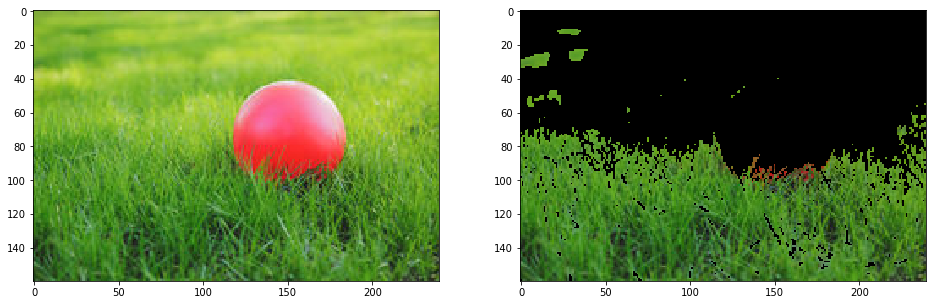

3275227.923480477
1637951.3687048003


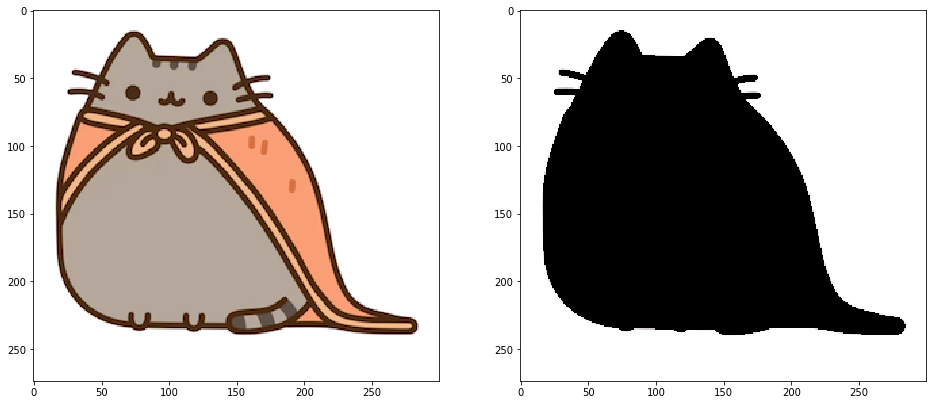

2191875.820834191
1096983.75481573


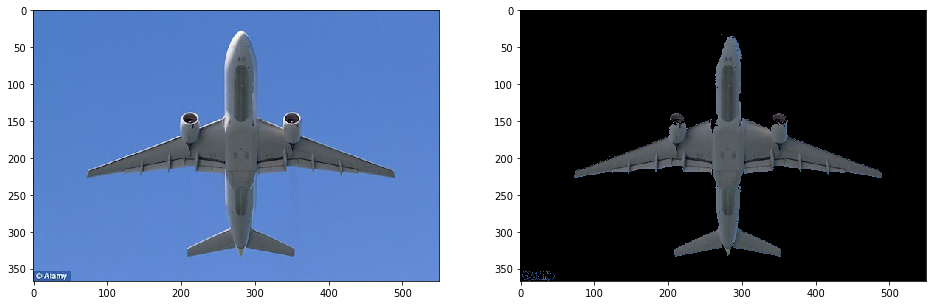

4204663.710258331
2103772.989306307


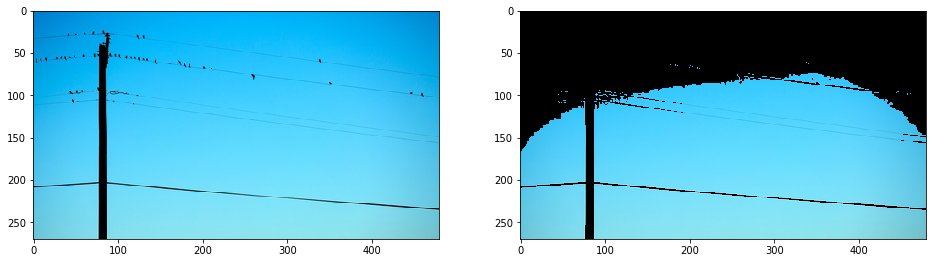

In [28]:
for img in imgs:
    c = simple_get_centers(img)
    print(process_img(img, simple_cut, c, False))
    process_img(img, my_cut, c, True)